In [1]:
from install import *
from test import *

import sys

def check_perf(generator, solver, compound, scale, batch):
  result = run_simulation(generator, solver, compound, scale, batch, batch)
  return result.perf.iloc[-1] - result.perf.iloc[0]
  
f = np.float32

def benchmark_solver(SolverClass, scale, batch, form=CoordFormat.nx, tpb=64,
                     scalar=True, compound=True, 
                     types = {s: f for s in ("pos_t", "vel_t", "time_t", "charge_t", "mass_t")},
                     GeneratorClass=TaskGenerator, init_kwargs={}):
  generator=GeneratorClass(scalar=scalar, **types)
  solver=SolverClass(coord_format=form, scalar=scalar, threadsperblock=tpb, types=types, **init_kwargs)
  return check_perf(generator, solver, compound, scale, batch)
  
def gen_scales_basic(max_pow=9):
  return [2**i for i in range(max_pow)]
      
def gen_scales(max_pow=9):
  def gen(m):
    for i in range(m-1):
      yield 2 * 2**i
      yield 3 * 2**i
  return list(gen(max_pow))
      
def gen_scales_extra(max_pow=9):
  def gen(m):
    yield 2
    yield 3
    for i in range(m-2):
      yield 4 * 2**i
      yield 5 * 2**i
      yield 6 * 2**i
      yield 7 * 2**i
  return list(gen(max_pow))


def good_batch_for_scale(s, max_batch=8192, crit1=24, crit2=64):
  if s<=crit1:
    return max_batch
  elif s<=crit2:
    return max_batch * crit1**2 / s**2
  else:
    return max_batch * crit1**2 * crit2**2 / s**4

def benchmark_all(solvers, scales=gen_scales_basic(), tpbs=one_tpbs, types=gen_one_types, params=gen_one_params, time_grow_limit=4, max_batch=8192):
  for solver, init_kwargs in solvers:
    s = solver.__name__
    print(s)
    row = {'solver': s}
    for t in types():
      tt = {k: v.__name__ for k, v in t.items()}
      print(tt)
      row.update(tt)
      for p in params():
        for tpb in (1,) if solver.no_blocks else tpbs:
          p['tpb'] = tpb
          pp = p.copy()
          pp["form"] = pp["form"].name
          print(pp)
          row.update(pp)
          for scale in scales:
            batch = good_batch_for_scale(scale, max_batch, *solver.perf_good_batch_crits)
            sys.stdout.write(f"{scale},{batch:.2f}: ")
            if batch > 1/time_grow_limit:
              batch = math.ceil(batch)
              time = benchmark_solver(solver, scale, batch, types=t, init_kwargs=init_kwargs, **p)
              sys.stdout.write(f"{time:.2f}; ")
              row['n'] = scale*scale
              row['batch'] = batch
              row['time'] = time
              yield row.copy()
            else:
              sys.stdout.write("; ")
          sys.stdout.write("\n")

            
def process_perf(perf):
  t = pd.DataFrame.from_records(list(perf))
  t["steptime"] = t.time / t.batch
  t["fps"] = t.batch / t.time
  t["pups"] = t.n * t.fps
  t["ops"] = t.n * t.pups
  return t
          
    
def timeplot(time_frame, xgroups=("solver",), groups=("solver",), **kwargs):
  gx = time_frame.groupby(xgroups)
  for x, d in gx:
    plt.subplots()
#   plt.figure()
#   g.fps.plot(legend=True, logx=True, logy=True, title="steps/second", **kwargs)
  plt.figure()
  g.pups.plot(legend=True, logx=True, logy=True, title="particles/second", **kwargs)
#   plt.figure()
#   g.ops.plot(legend=True, logx=True, logy=True, title="interactions/second", **kwargs)

GPU_solvers = [(NumbaSolver, {}), (CudaSolver, {}), (OpenCLSolver, {})]
CPU_solvers = [(NumpySolver, {}), (PythonSolver, {}), (OpenCLSolver, {"platform": 1, "CPU":True})]
limited_solvers = [(NumbaJitSolver, {})]

NumbaSolver.perf_good_batch_crits = (12, 24)
CudaSolver.perf_good_batch_crits = (12, 24)
OpenCLSolver.perf_good_batch_crits = (12, 24)

 there is nothing to do
 there is nothing to do
 there is nothing to do
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Mon Dec 10 14:06:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.22       Driver Version: 415.22       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GT 640      Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   39C    P0    N/A /  N/A |    274MiB /  1996MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
         

  Preferred work group size multiple              128
  Max sub-groups per work group                   1
  Preferred / native vector sizes                 
    char                                                 1 / 32      
    short                                                1 / 16      
    int                                                  1 / 8       
    long                                                 1 / 4       
    half                                                 0 / 0        (n/a)
    float                                                1 / 8       
    double                                               1 / 4        (cl_khr_fp64)
  Half-precision Floating-point support           (n/a)
  Single-precision Floating-point support         (core)
    Denormals                                     Yes
    Infinity and NANs                             Yes
    Round to nearest                              Yes
    Round to zero                                 No
    R


OpenCL Platforms and Devices
Platform - Name:  NVIDIA CUDA
Platform - Vendor:  NVIDIA Corporation
Platform - Version:  OpenCL 1.2 CUDA 10.0.132
Platform - Profile:  FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  GeForce GT 640
    Device - Type:  GPU
    Device - Max Clock Speed:  901 Mhz
    Device - Compute Units:  2
    Device - Local Memory:  48 KB
    Device - Constant Memory:  64 KB
    Device - Global Memory: 2 GB
Platform - Name:  Intel(R) CPU Runtime for OpenCL(TM) Applications
Platform - Vendor:  Intel(R) Corporation
Platform - Version:  OpenCL 2.1 LINUX
Platform - Profile:  FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  Intel(R) Core(TM) i3-4330 CPU @ 3.50GHz
    Device - Type:  CPU
    Device - Max Clock Speed:  3500 Mhz
    Device - Compute Units:  4
    Device - Local Memory:  32 KB
    Device - Constant Memory:  128 KB
    Device - Global Memory: 8 GB




## ThreadsPerBlock

In [2]:
raw = list(benchmark_all(GPU_solvers, tpbs=many_tbps))

NumbaSolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 8}
1,8192.00: 4.85; 2,8192.00: 4.70; 4,8192.00: 4.65; 8,8192.00: 4.60; 16,4608.00: 2.87; 32,648.00: 5.94; 64,40.50: 5.86; 128,2.53: 6.92; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 16}
1,8192.00: 4.66; 2,8192.00: 4.69; 4,8192.00: 4.64; 8,8192.00: 4.65; 16,4608.00: 2.90; 32,648.00: 3.13; 64,40.50: 3.16; 128,2.53: 3.64; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 32}
1,8192.00: 4.70; 2,8192.00: 4.72; 4,8192.00: 4.70; 8,8192.00: 4.67; 16,4608.00: 2.84; 32,648.00: 1.78; 64,40.50: 1.84; 128,2.53: 2.05; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 48}
1,8192.00: 4.81; 2,8192.00: 4.65; 4,8192.00: 4.65; 8,8192.00: 4.66; 16,4608.00: 2.86; 32,648.00: 1.89; 64,40.50: 1.49; 128,2.53: 1.58; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': Tru

In [14]:
tpb = process_perf(raw)
tpb.to_csv("tpb.csv", index=False)
tpb.head(2)

,batch,charge_t,compound,form,mass_t,n,pos_t,scalar,solver,time,time_t,tpb,vel_t,steptime,fps,pups,ops
0,8192,float32,True,nx,float32,1,float32,False,NumbaSolver,4.853053,float32,8,float32,0.000592,1688.009651,1688.009651,1688.009651
1,8192,float32,True,nx,float32,4,float32,False,NumbaSolver,4.700032,float32,8,float32,0.000574,1742.966842,6971.867368,27887.469471


In [15]:
tpb = pd.read_csv('tpb.csv')
tpb.head(2)

,batch,charge_t,compound,form,mass_t,n,pos_t,scalar,solver,time,time_t,tpb,vel_t,steptime,fps,pups,ops
0,8192,float32,True,nx,float32,1,float32,False,NumbaSolver,4.853053,float32,8,float32,0.000592,1688.009651,1688.009651,1688.009651
1,8192,float32,True,nx,float32,4,float32,False,NumbaSolver,4.700032,float32,8,float32,0.000574,1742.966842,6971.867368,27887.469471


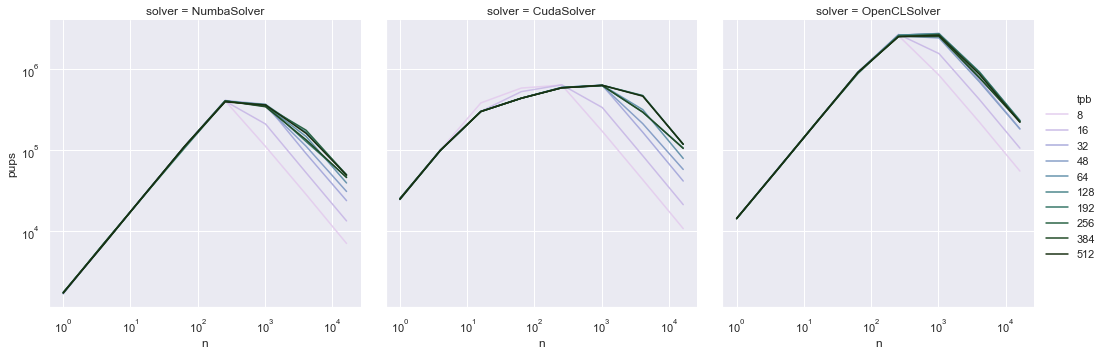

In [69]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.set()
palette = sns.cubehelix_palette(start=1.5, rot=.7, n_colors=10)
sns.relplot(data=tpb, kind='line', x='n', y='pups', col='solver', hue='tpb', palette=palette).set(xscale="log", yscale="log")

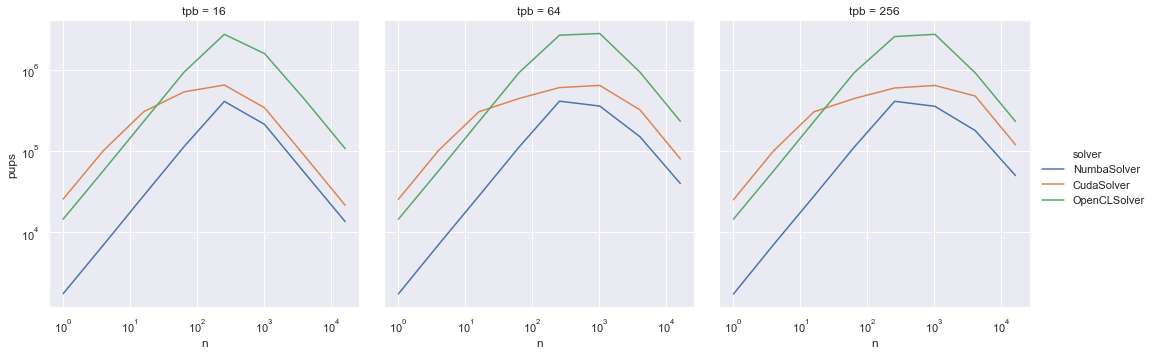

In [70]:
sns.relplot(data=tpb[np.in1d(tpb.tpb, (16, 64, 256))], kind='line', x='n', y='pups', col='tpb', hue='solver').set(xscale="log", yscale="log")

### results
 - opencl is fastest!
 - cuda is lower overhead for small jobs (irrelevant)
 - numba is slower

## Scalar and types

In [66]:
raw = list(benchmark_all(GPU_solvers, params=gen_sane_params, types=gen_sane_types))
gpu = process_perf(raw)
gpu.to_csv("gpu.csv", index=False)

NumbaSolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'int32', 'charge_t': 'int32'}
{'form': 'nx', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 4.42; 2,8192.00: 4.26; 4,8192.00: 4.33; 8,8192.00: 4.24; 16,4608.00: 2.57; 32,648.00: 1.71; 64,40.50: 1.03; 128,2.53: 1.15; 256,0.16: ; 
{'form': 'nx', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 1.82; 2,8192.00: 1.66; 4,8192.00: 1.66; 8,8192.00: 1.82; 16,4608.00: 2.39; 32,648.00: 1.48; 64,40.50: 1.03; 128,2.53: 1.09; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 4.72; 2,8192.00: 4.92; 4,8192.00: 4.69; 8,8192.00: 4.82; 16,4608.00: 2.91; 32,648.00: 2.06; 64,40.50: 1.78; 128,2.53: 1.98; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 2.23; 2,8192.00: 2.14; 4,8192.00: 2.11; 8,8192.00: 2.24; 16,4608.00: 2.71; 32,648.00: 1.99; 64,40.50: 1.53; 128,2.53: 1.86; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': True, '

1,8192.00: 1.67; 2,8192.00: 1.77; 4,8192.00: 1.68; 8,8192.00: 1.68; 16,4608.00: 2.80; 32,648.00: 2.56; 64,40.50: 2.55; 128,2.53: 3.06; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 4.72; 2,8192.00: 4.80; 4,8192.00: 4.69; 8,8192.00: 4.68; 16,4608.00: 3.16; 32,648.00: 2.90; 64,40.50: 2.92; 128,2.53: 3.30; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 2.12; 2,8192.00: 2.24; 4,8192.00: 2.12; 8,8192.00: 2.12; 16,4608.00: 2.89; 32,648.00: 2.74; 64,40.50: 2.73; 128,2.53: 3.28; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 4.31; 2,8192.00: 4.33; 4,8192.00: 4.24; 8,8192.00: 4.27; 16,4608.00: 2.80; 32,648.00: 2.67; 64,40.50: 2.61; 128,2.53: 3.14; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 1.67; 2,8192.00: 1.65; 4,8192.00: 1.78; 8,8192.00: 1.66; 16,4608.00: 2.54; 32,648.00: 2.65; 64,40.50: 2.55; 128,2.53: 2.95; 256,0.16: ; 
{'form': 'xn', '

1,8192.00: 0.33; 2,8192.00: 0.32; 4,8192.00: 0.43; 8,8192.00: 1.20; 16,4608.00: 2.00; 32,648.00: 1.03; 64,40.50: 0.52; 128,2.53: 0.61; 256,0.16: ; 
{'form': 'nx', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 0.13; 2,8192.00: 0.13; 4,8192.00: 0.23; 8,8192.00: 0.83; 16,4608.00: 1.82; 32,648.00: 1.04; 64,40.50: 0.55; 128,2.53: 0.66; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 0.32; 2,8192.00: 0.32; 4,8192.00: 0.42; 8,8192.00: 1.14; 16,4608.00: 1.86; 32,648.00: 0.99; 64,40.50: 0.52; 128,2.53: 0.61; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 0.12; 2,8192.00: 0.12; 4,8192.00: 0.21; 8,8192.00: 0.73; 16,4608.00: 1.59; 32,648.00: 0.91; 64,40.50: 0.48; 128,2.53: 0.58; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 0.32; 2,8192.00: 0.33; 4,8192.00: 0.43; 8,8192.00: 1.19; 16,4608.00: 1.96; 32,648.00: 1.03; 64,40.50: 0.52; 128,2.53: 0.61; 256,0.16: ; 
{'form': 'xn', '

1,8192.00: 0.13; 2,8192.00: 0.13; 4,8192.00: 0.27; 8,8192.00: 1.00; 16,4608.00: 2.20; 32,648.00: 2.19; 64,40.50: 2.22; 128,2.53: 2.62; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 0.32; 2,8192.00: 0.31; 4,8192.00: 0.46; 8,8192.00: 1.28; 16,4608.00: 2.10; 32,648.00: 2.07; 64,40.50: 2.05; 128,2.53: 2.37; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 0.12; 2,8192.00: 0.12; 4,8192.00: 0.25; 8,8192.00: 0.90; 16,4608.00: 1.97; 32,648.00: 2.07; 64,40.50: 2.09; 128,2.53: 2.48; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 0.32; 2,8192.00: 0.32; 4,8192.00: 0.50; 8,8192.00: 1.40; 16,4608.00: 2.31; 32,648.00: 2.22; 64,40.50: 2.19; 128,2.53: 2.55; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 0.13; 2,8192.00: 0.13; 4,8192.00: 0.27; 8,8192.00: 0.98; 16,4608.00: 2.14; 32,648.00: 2.19; 64,40.50: 2.22; 128,2.53: 2.62; 256,0.16: ; 
{'form': 'split'

1,8192.00: 0.54; 2,8192.00: 0.55; 4,8192.00: 0.56; 8,8192.00: 0.55; 16,4608.00: 0.32; 32,648.00: 0.16; 64,40.50: 0.10; 128,2.53: 0.12; 256,0.16: ; 
{'form': 'xn', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 0.22; 2,8192.00: 0.21; 4,8192.00: 0.21; 8,8192.00: 0.27; 16,4608.00: 0.54; 32,648.00: 0.31; 64,40.50: 0.17; 128,2.53: 0.20; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 0.57; 2,8192.00: 0.56; 4,8192.00: 0.57; 8,8192.00: 0.59; 16,4608.00: 0.46; 32,648.00: 0.23; 64,40.50: 0.15; 128,2.53: 0.17; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 0.23; 2,8192.00: 0.23; 4,8192.00: 0.23; 8,8192.00: 0.36; 16,4608.00: 0.74; 32,648.00: 0.42; 64,40.50: 0.22; 128,2.53: 0.26; 256,0.16: ; 
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 0.63; 2,8192.00: 0.63; 4,8192.00: 0.63; 8,8192.00: 0.63; 16,4608.00: 0.36; 32,648.00: 0.16; 64,40.50: 0.10; 128,2.53: 0.12; 256,0.16: ; 
{'form': 'spl

1,8192.00: 0.21; 2,8192.00: 0.21; 4,8192.00: 0.25; 8,8192.00: 0.89; 16,4608.00: 1.92; 32,648.00: 2.04; 64,40.50: 2.06; 128,2.53: 2.43; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': True, 'tpb': 64}
1,8192.00: 0.57; 2,8192.00: 0.57; 4,8192.00: 0.57; 8,8192.00: 1.43; 16,4608.00: 2.33; 32,648.00: 2.23; 64,40.50: 2.21; 128,2.53: 2.56; 256,0.16: ; 
{'form': 'xn', 'scalar': False, 'compound': False, 'tpb': 64}
1,8192.00: 0.23; 2,8192.00: 0.23; 4,8192.00: 0.27; 8,8192.00: 0.96; 16,4608.00: 2.08; 32,648.00: 2.15; 64,40.50: 2.18; 128,2.53: 2.57; 256,0.16: ; 
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
1,8192.00: 0.64; 2,8192.00: 0.64; 4,8192.00: 0.63; 8,8192.00: 1.30; 16,4608.00: 2.11; 32,648.00: 2.06; 64,40.50: 2.03; 128,2.53: 2.34; 256,0.16: ; 
{'form': 'split', 'scalar': True, 'compound': False, 'tpb': 64}
1,8192.00: 0.24; 2,8192.00: 0.24; 4,8192.00: 0.25; 8,8192.00: 0.89; 16,4608.00: 1.93; 32,648.00: 2.01; 64,40.50: 2.04; 128,2.53: 2.40; 256,0.16: ; 
{'form': '

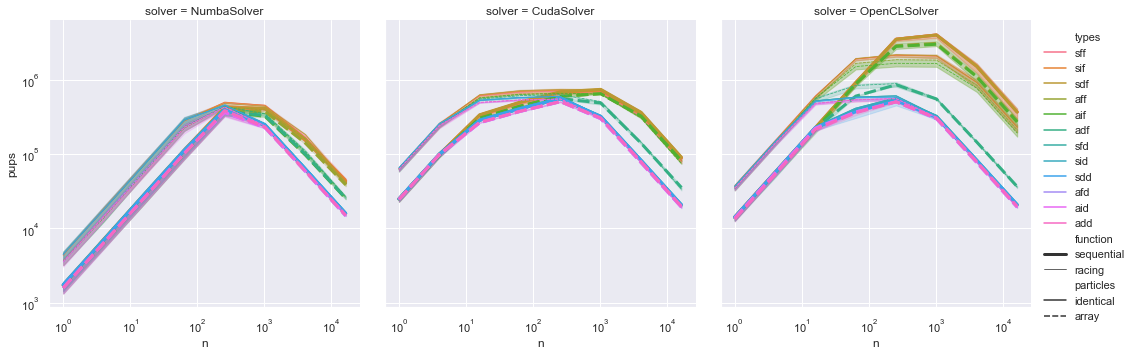

In [90]:
d=pd.read_csv('gpu.csv')
map_type = lambda t: {'int32': 'i', 'float32': 'f', 'float64': 'd'}.get(t, t)
d['mt'] = np.vectorize(map_type)(d.mass_t)
d['pt'] = np.vectorize(map_type)(d.pos_t)
d['sc'] = np.vectorize(lambda s: {True: 's', False: 'a'}.get(s, s))(d.scalar)
d['types'] = d.sc + d.mt + d.pt
d['types'] = d.types.astype('category').cat.reorder_categories([
    'sff','sif','sdf','aff','aif','adf','sfd','sid','sdd','afd','aid','add'])
d['function'] = np.vectorize(lambda c: 'sequential' if c else 'racing')(d['compound'])
d['particles'] = np.vectorize(lambda c: 'identical' if c else 'array')(d.scalar)
sns.relplot(data=d, kind='line', x='n', y='pups', col='solver', hue='types', size='function', style='particles').set(xscale="log", yscale="log")


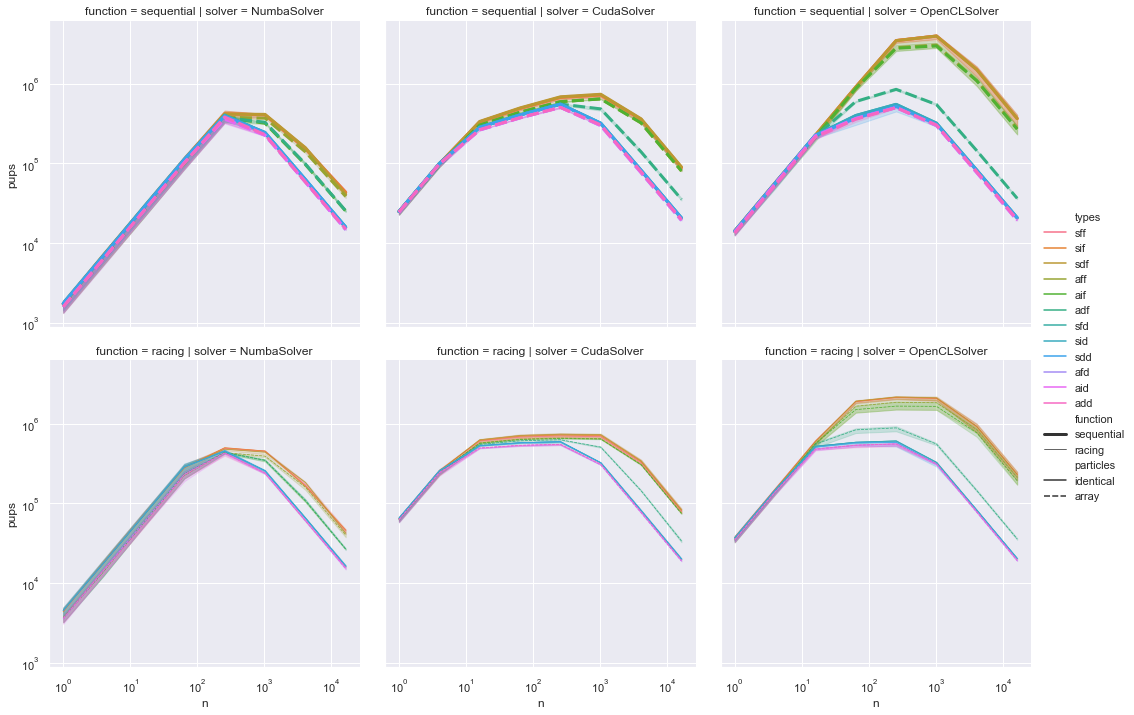

In [91]:
sns.relplot(data=d, kind='line', x='n', y='pups', col='solver', hue='types', size='function', style='particles', row='function').set(xscale="log", yscale="log")

### results
 - all have the same shape: 
   1. constant overhead-dominated part 
   2. linear by n (so not using the whole gpu)
   3. quadratic of| n (full utilization)
 - at small scale only compound function overhead matters

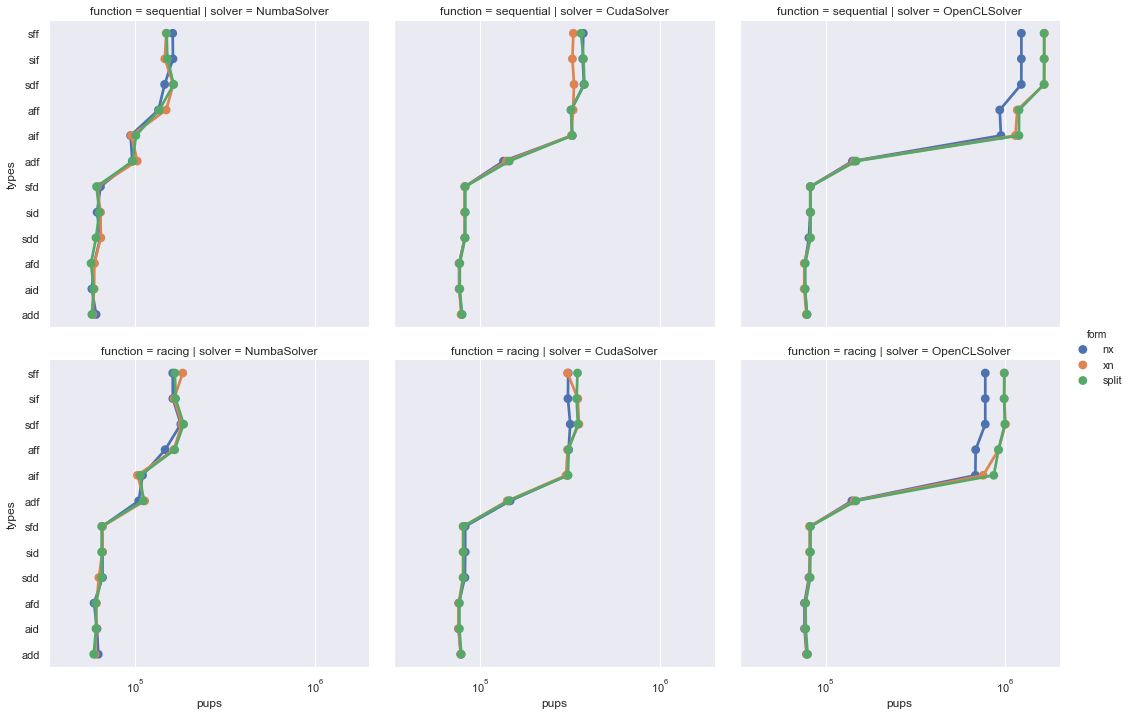

In [101]:
d4 = d[d.n==4096]
sns.catplot(data=d4, x='pups', kind='point', y='types', row='function', col='solver', hue='form').set(xscale="log")

### resiults
 - opencl accelerates a lot without double precision
 - scalar charges and masses improve performance
 - coordinate form has very minor effect, maybe nx is slower on opencl

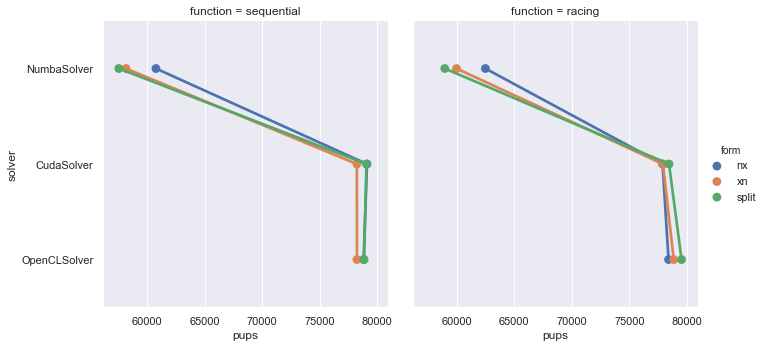

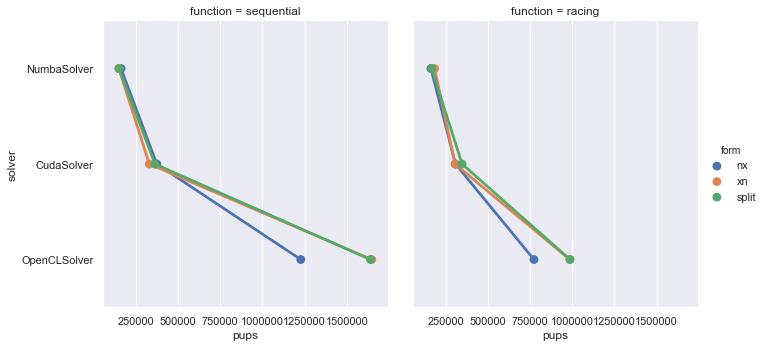

In [106]:
sns.catplot(data=d4[d4.types=='add'], kind='point', col='function', y='solver', x='pups', hue='form')
sns.catplot(data=d4[d4.types=='sff'], kind='point', col='function', y='solver', x='pups', hue='form')

### resiults
 - for double precision cuda is as fast as opencl
 - for float nx is slower on opencl, otherwise very close
 - compound (separate functions) is for some reason faster (probably auto-const some arrays).

### GPU conclusions:
 - set "threads per block" to a big enough value
 - sequential (compound) is faster *and* more correct for the large scale that we care about
 - 1d split coordinate arrays are simple and fast
 - int data does not help
 - numba is slow
 - float is fast, especially on opencl
 - not using arrays for particle parameters helps
 
 Final parameters: 256+ tpb, sequential function, split arrays, all data of the same type (float or double), Cuda or OpenCL, scalar parameters
 

## CPU solvers

In [110]:
def gen_limited_params():
  form = CoordFormat.split
  scalar = True
  compound = True
  yield locals()
  
raw = list(benchmark_all(limited_solvers+CPU_solvers, scales=gen_scales(), types=gen_sane_types, params=gen_limited_params))

NumbaJitSolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'int32', 'charge_t': 'int32'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 1}
2,8192.00: 4.48; 3,8192.00: 0.63; 4,8192.00: 0.91; 6,8192.00: 1.66; 8,4608.00: 1.61; 12,910.22: 0.78; 16,288.00: 0.52; 24,56.89: 0.30; 32,18.00: 0.23; 48,3.56: 0.17; 64,1.12: 0.23; 96,0.22: ; 128,0.07: ; 192,0.01: ; 256,0.00: ; 384,0.00: ; 
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 1}
2,8192.00: 1.43; 3,8192.00: 0.64; 4,8192.00: 0.91; 6,8192.00: 1.68; 8,4608.00: 1.63; 12,910.22: 0.77; 16,288.00: 0.51; 24,56.89: 0.29; 32,18.00: 0.20; 48,3.56: 0.16; 64,1.12: 0.22; 96,0.22: ; 128,0.07: ; 192,0.01: ; 256,0.00: ; 384,0.00: ; 
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float64', 'charge_t': 'float64'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 1}
2,8

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.87; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.87; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.82; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.55; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.07; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.93; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.96; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.06; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.77; 256,0.16: ; 384,0.03: ; 
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.81; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.70; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.32; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.94; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.93; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.05; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.83; 256,0.16: ; 384,0.03: ; 
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float64', 'charge_t': 'float64'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.90; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.83; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.82; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.73; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.24; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.09; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.96; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.05; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.77; 256,0.16: ; 384,0.03: ; 
{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'int32', 'charge_t': 'int32'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.78; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.26; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.86; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


4.27; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.68; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.53; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.59; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.47; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


4.10; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


6.94; 256,0.16: ; 384,0.03: ; 
{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float32', 'charge_t': 'float32'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.90; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.77; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.39; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.91; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.98; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.68; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.48; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.63; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.50; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


4.16; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


6.94; 256,0.16: ; 384,0.03: ; 
{'pos_t': 'float64', 'vel_t': 'float64', 'time_t': 'float64', 'mass_t': 'float64', 'charge_t': 'float64'}
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.78; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.44; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


4.08; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.66; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.54; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.53; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


3.45; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


4.09; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


6.90; 256,0.16: ; 384,0.03: ; 


In [111]:
cpu = process_perf(raw)
cpu.to_csv("cpu.csv", index=False)


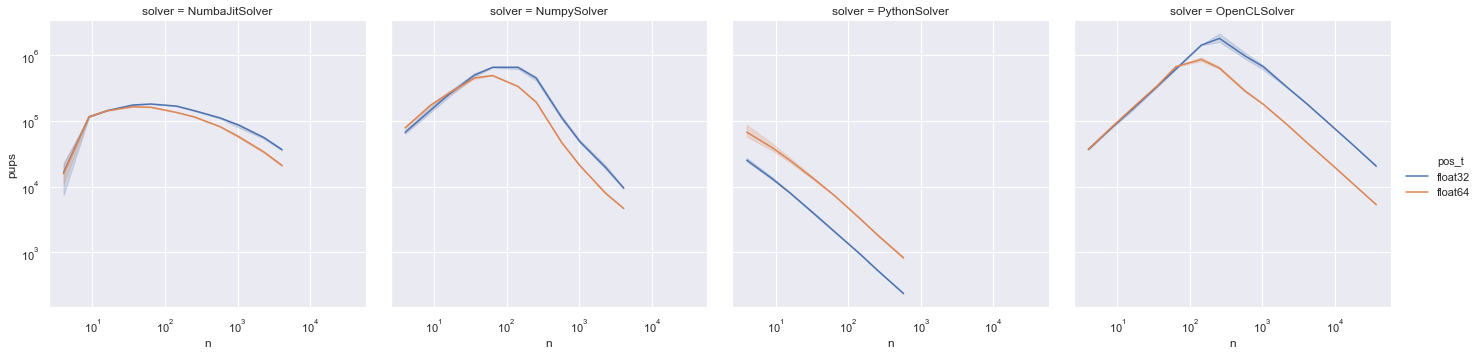

In [116]:
cpu = pd.read_csv("cpu.csv")
sns.relplot(data=cpu, kind='line', x='n', y='pups', col='solver', hue='pos_t').set(xscale="log", yscale="log")


### results
 - python has no parallelizm at all
 - the rest are saturated at ~ 10^2 particles
 - python prefers double (no type conversion)

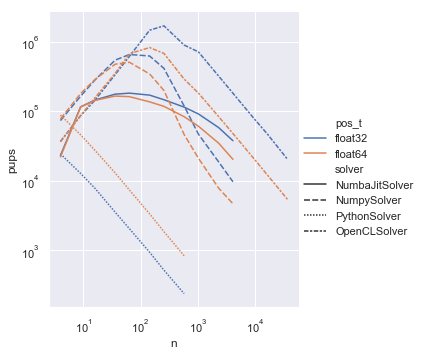

In [122]:
sns.relplot(data=cpu[cpu.pos_t==cpu.mass_t],
            kind='line', x='n', y='pups', style='solver', hue='pos_t').set(xscale="log", yscale="log")

### results
 - overhead for Jit compiling, opencl and python floats
 - numba Jit only overtakes Numpy at scale > 1000
 - opencl is fastest again
 - for small scale numpy is great


In [123]:
raw = list(benchmark_all(CPU_solvers, scales=gen_scales(), types=gen_one_types, params=gen_sane_params))

NumpySolver
{'pos_t': 'float32', 'vel_t': 'float32', 'time_t': 'float32', 'mass_t': 'float32', 'charge_t': 'float32'}
{'form': 'nx', 'scalar': True, 'compound': True, 'tpb': 1}
2,8192.00: 0.35; 3,8192.00: 0.36; 4,8192.00: 0.45; 6,8192.00: 0.83; 8,4608.00: 1.01; 12,910.22: 0.81; 16,288.00: 0.79; 24,56.89: 0.89; 32,18.00: 0.91; 48,3.56: 1.14; 64,1.12: 1.86; 96,0.22: ; 128,0.07: ; 192,0.01: ; 256,0.00: ; 384,0.00: ; 
{'form': 'nx', 'scalar': True, 'compound': False, 'tpb': 1}
2,8192.00: 0.32; 3,8192.00: 0.34; 4,8192.00: 0.42; 6,8192.00: 0.81; 8,4608.00: 0.99; 12,910.22: 0.81; 16,288.00: 0.78; 24,56.89: 0.89; 32,18.00: 0.90; 48,3.56: 1.13; 64,1.12: 1.86; 96,0.22: ; 128,0.07: ; 192,0.01: ; 256,0.00: ; 384,0.00: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 1}
2,8192.00: 0.36; 3,8192.00: 0.39; 4,8192.00: 0.47; 6,8192.00: 0.87; 8,4608.00: 1.05; 12,910.22: 0.86; 16,288.00: 0.81; 24,56.89: 0.91; 32,18.00: 0.94; 48,3.56: 1.23; 64,1.12: 1.99; 96,0.22: ; 128,0.07: ; 192,0.01: ; 256,0

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.76; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.74; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.66; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.62; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.22; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.01; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.97; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.15; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.93; 256,0.16: ; 384,0.03: ; 
{'form': 'nx', 'scalar': True, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.31; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.29; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.30; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.30; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.28; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.42; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.51; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.18; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.98; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.97; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.94; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.12; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.99; 256,0.16: ; 384,0.03: ; 
{'form': 'nx', 'scalar': False, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.77; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.77; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.76; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.76; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.80; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.67; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.63; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.22; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.02; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.97; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.15; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.93; 256,0.16: ; 384,0.03: ; 
{'form': 'nx', 'scalar': False, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.33; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.32; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.32; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.31; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.30; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.45; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.53; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.18; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.02; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.98; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.99; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.96; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.14; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.92; 256,0.16: ; 384,0.03: ; 
{'form': 'xn', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.75; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.74; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.74; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.67; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.53; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.06; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.90; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.78; 256,0.16: ; 384,0.03: ; 
{'form': 'xn', 'scalar': True, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.29; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.29; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.30; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.29; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.28; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.46; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.03; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'xn', 'scalar': False, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.80; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.77; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.77; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.78; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.76; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.70; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.52; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.06; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.94; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.03; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'xn', 'scalar': False, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.36; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.33; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.33; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.32; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.38; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.46; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.87; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'split', 'scalar': True, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.86; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.87; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.85; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.87; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.82; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.53; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.08; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'split', 'scalar': True, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.34; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.34; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.33; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.38; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.47; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.06; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.90; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'split', 'scalar': False, 'compound': True, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.93; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.96; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.91; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.84; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.54; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.06; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.93; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.93; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.75; 256,0.16: ; 384,0.03: ; 
{'form': 'split', 'scalar': False, 'compound': False, 'tpb': 64}
2,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.40; 3,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.36; 4,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.36; 6,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 8,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.35; 12,8192.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.39; 16,4608.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.49; 24,2048.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.20; 32,648.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.92; 48,128.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.89; 64,40.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.90; 96,8.00: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


0.88; 128,2.53: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.04; 192,0.50: 

/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
/usr/lib/python3.7/site-packages/pyopencl/cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


1.74; 256,0.16: ; 384,0.03: ; 


In [125]:
cpup = process_perf(raw)
cpup.to_csv("cpup.csv", index=False)

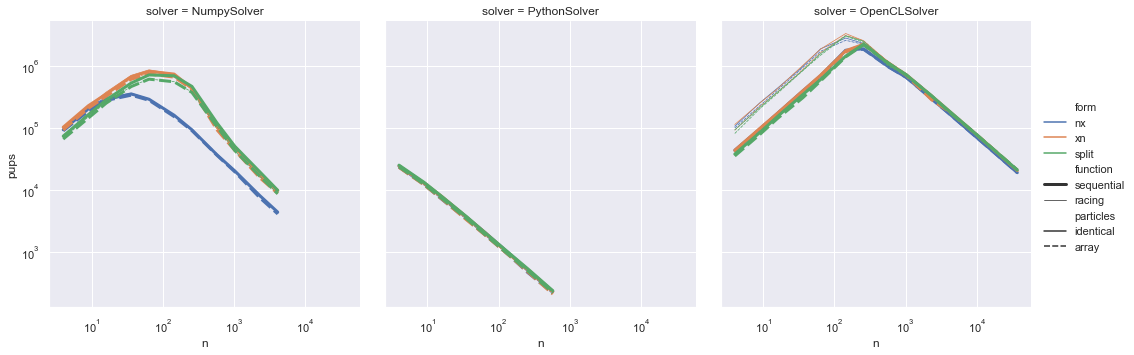

In [131]:
d=pd.read_csv('cpup.csv')
d['function'] = np.vectorize(lambda c: 'sequential' if c else 'racing')(d['compound'])
d['particles'] = np.vectorize(lambda c: 'identical' if c else 'array')(d.scalar)
sns.relplot(data=d, kind='line', x='n', y='pups', hue='form', size='function', style='particles', col='solver').set(xscale="log", yscale="log")

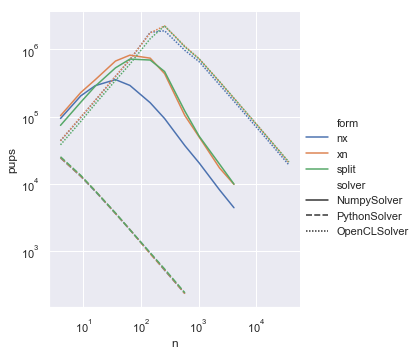

In [134]:
sns.relplot(data=d[np.logical_and(d['compound'], d.scalar)], kind='line', x='n', y='pups', hue='form', style='solver').set(xscale="log", yscale="log")

### CPU results
 - only numpy cares about coord format, does not like nx (probably my fault)
 - scalar is a bit faster, but not relevantly
 - compound only affects OpenCL overhead
 - use OpenCL

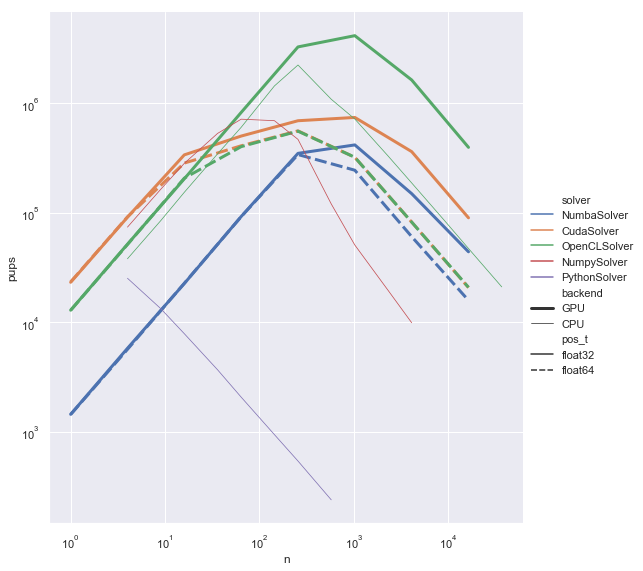

In [148]:
gpu['backend']='GPU'
cpup['backend']='CPU'
o=pd.concat((gpu, cpup))
o=o[o['compound']]
o=o[o.scalar]
o=o[o.form=='split']
o=o[o.pos_t==o.mass_t]
sns.relplot(height=8, data=o, kind='line', x='n', y='pups', 
            style='pos_t', hue='solver', size='backend').set(xscale="log", yscale="log")

### Comparison
 - A small GPU is faster
 - OpenCL is great